[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.5624 - loss: 0.6796 - val_accuracy: 0.7072 - val_loss: 0.5512
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7909 - loss: 0.4555 - val_accuracy: 0.8307 - val_loss: 0.3976
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8599 - loss: 0.3425 - val_accuracy: 0.8551 - val_loss: 0.3379
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8990 - loss: 0.2591 - val_accuracy: 0.7376 - val_loss: 1.5902
Epoch 5/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9153 - loss: 0.2348 - val_accuracy: 0.8788 - val_loss: 0.3179
Epoch 6/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9289 - loss: 0.1946 - val_accuracy: 0.8787 - val_loss: 0.3330
Epoch 7/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9337 - loss: 0.1847 - val_accuracy: 0.8445 - val_loss: 0.4583
Epoch 8/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9444 - loss: 0.1617 - val_accurac

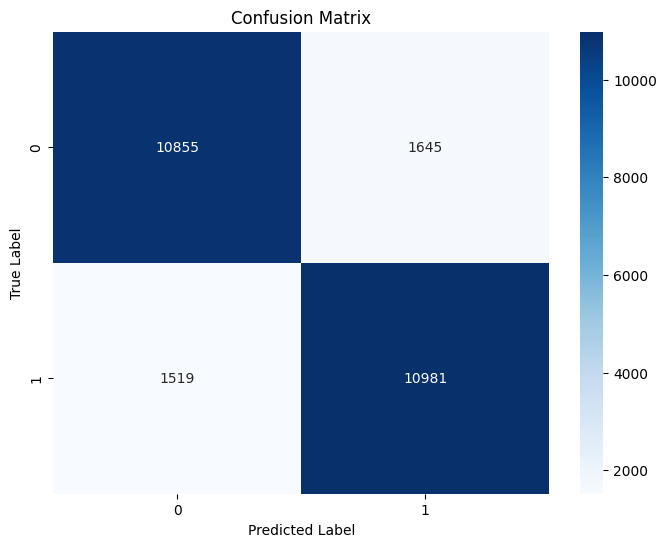

Accuracy:  0.8734
Precision: 0.8697
Recall:    0.8785
F1-Score:  0.8741


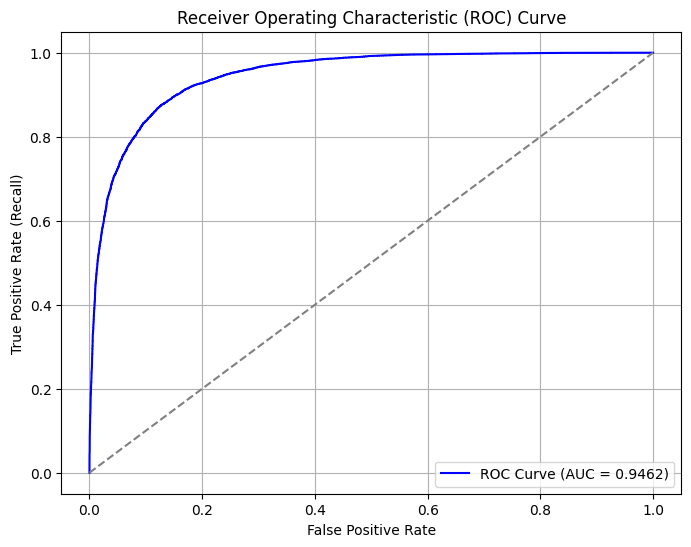

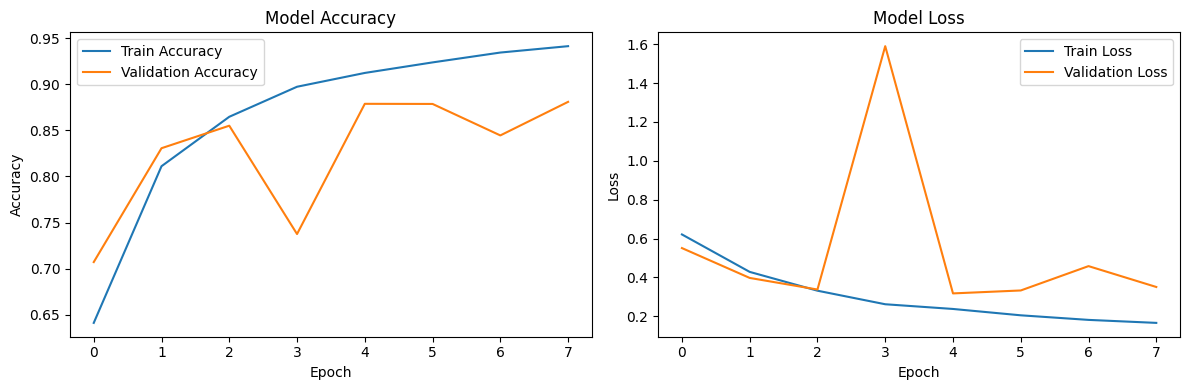

Sentence: This movie was fantastic, I loved it!
Predicted Sentiment: Positive (Confidence: 99.15%)
Sentence: Absolutely terrible, the worst film ever.
Predicted Sentiment: Negative (Confidence: 99.48%)
Sentence: Not bad, but could have been better.
Predicted Sentiment: Negative (Confidence: 70.10%)
Sentence: I enjoyed the story and the acting was great.
Predicted Sentiment: Positive (Confidence: 99.12%)
Sentence: Awful, boring, and not worth watching.
Predicted Sentiment: Negative (Confidence: 99.34%)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Load and preprocess IMDB dataset
def load_imdb_data(num_words=20000, max_length=500):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=num_words)
    x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
    x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')
    return x_train, y_train, x_test, y_test

# Prepare tokenizer aligned with IMDB word index
def prepare_tokenizer(num_words = 20000):
    word_index = tf.keras.datasets.imdb.get_word_index()
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.word_index = {k: (v + 3) for k, v in word_index.items()}
    tokenizer.word_index["<PAD>"] = 0
    tokenizer.word_index["<START>"] = 1
    tokenizer.word_index["<UNK>"] = 2
    tokenizer.word_index["<UNUSED>"] = 3
    return tokenizer

# Clean input text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s']", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

# Create enhanced GRU model
def create_gru_model(embedding_dim=128, units=128, dropout_rate=0.4, optimizer='adam', max_length=500, num_words = 20000):
    model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_length),
        GRU(units, dropout=dropout_rate, return_sequences=True),
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Evaluate with ROC Curve
def evaluate_with_roc(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # ROC and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main function
def main():
    x_train, y_train, x_test, y_test = load_imdb_data(max_length=300)
    tokenizer = prepare_tokenizer()

    # Split training data
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

    # Create and train GRU model
    optimizer = RMSprop(learning_rate=0.0005)
    gru_model = create_gru_model(optimizer=optimizer, max_length=300, num_words = 20000)
    history = gru_model.fit(
        x_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(x_val, y_val),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=1
    )

    # Evaluate on test data
    y_pred = gru_model.predict(x_test, verbose=0).flatten()
    evaluate_with_roc(y_test, y_pred)

    # Plot training history
    plot_training_history(history)

    # Test predictions
    test_sentences = [
        "This movie was fantastic, I loved it!",
        "Absolutely terrible, the worst film ever.",
        "Not bad, but could have been better.",
        "I enjoyed the story and the acting was great.",
        "Awful, boring, and not worth watching."
    ]
    for sentence in test_sentences:
        text = clean_text(sentence)
        seq = tokenizer.texts_to_sequences([text])
        padded_seq = pad_sequences(seq, maxlen=300, padding='post', truncating='post')
        prediction = gru_model.predict(padded_seq, verbose=0)[0][0]
        sentiment = "Positive" if prediction > 0.5 else "Negative"
        confidence = prediction if prediction > 0.5 else 1 - prediction
        print(f"Sentence: {sentence}")
        print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.2%})")

if __name__ == '__main__':
    main()